# Fake News Classification

### Grace Li

Outline:
1. Construct a new TensorFlow dataset with cleaned and vectorized text data
2. Build neural network models that classify whether an article is fake or real news. One model takes in just the article title, one takes in just the text, and one takes in both using a functional API
3. Plot and evaluate training vs validation data
4. Compare which model performed best to decide the optimal method of detecting fake news

## Import Libraries

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import string
import re

from tensorflow import keras
from tensorflow.keras import layers, Model, Input, losses
from tensorflow.keras import losses

## Acquiring data

First I read the csv file from the given link 

    train_url = "https://github.com/PhilChodrow/PIC16b/blob/master/datasets/fake_news_train.csv?raw=true"

In [2]:
#read url
df = pd.read_csv(f'https://github.com/PhilChodrow/PIC16b/blob/master/datasets/fake_news_train.csv?raw=true')

#keep only necessary columns
df = df[["title", "text", "fake"]]

#make sure our dataset loaded appropriately
df.head()

,title,text,fake
0,Merkel: Strong result for Austria's FPO 'big c...,German Chancellor Angela Merkel said on Monday...,0
1,Trump says Pence will lead voter fraud panel,"WEST PALM BEACH, Fla.President Donald Trump sa...",0
2,JUST IN: SUSPECTED LEAKER and “Close Confidant...,"On December 5, 2017, Circa s Sara Carter warne...",1
3,Thyssenkrupp has offered help to Argentina ove...,"Germany s Thyssenkrupp, has offered assistance...",0
4,Trump say appeals court decision on travel ban...,President Donald Trump on Thursday called the ...,0


Notice this dataframe contains the title of articles, the full text from that article, and a binary indication of whether the article is fake news.

## Make Datasets

Now I create function called `make_dataset`. This function will do four things:

1. Change the text to lowercase.

2. Remove stopwords from the article text and title. A stopword is a word that is usually considered to be uninformative, such as “the,” “and,” or “but”. 

3. Construct and return a tf.data.Dataset with two inputs and one output. The input will be of the form (title, text), and the output consists only of the fake column.

4. Batch the dataset prior to returning it in order to increase speed of training, found that batches of 50 rows work best to preserve accuracy.

In [3]:
def make_dataset(df):
    '''
    Takes in a dataframe, changes all its text to lowercase and removes stopwords,
    then converts the dataset to a tensorflow dataset and returns the batched dataset
    
    Parameters:
    df: a pd data frame, in our case it has title, text, and fake columns
    
    Returns:
    dataset: a tf dataset that has one input in the form (title, text) and one output which is the fake column
    
    '''
    
    
    #define collection of stopwords
    stop = stopwords.words('english')
    
    # remove capital letters by changing all to lowercase
    df['text'] = df['text'].str.lower()
    df['title'] = df['title'].str.lower()
    
    #remove stopwords
    df['text'] = df['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
    df['title'] = df['title'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
    
    # Convert columns to TensorFlow tensors
    titles = tf.constant(df['title'].values, dtype=tf.string)
    texts = tf.constant(df['text'].values, dtype=tf.string)
    labels = tf.constant(df['fake'].values, dtype=tf.int32)
    
    #make tf dataset with two inputs (title, text) and one output (fake column)
    dataset = tf.data.Dataset.from_tensor_slices((
        {"title": titles, "text": texts}, 
        labels
    ))
    
    #batch dataset with 50 row batches
    dataset = dataset.batch(50)
    
    #return new dataset
    return dataset
    
dataset = make_dataset(df)


## Train test split:

Next, I write a function `train_test_split` to do train test split for any tensorflow dataset and use the function on our dataset with 80% training size and 20% validation.

In [4]:
def train_test_split (dataset, train_percent):
    '''
    Perform train test split on any tensorflow dataset
    
    Parameters:
    dataset: a tensorflow dataset
    train_percent: a float between 0 and 1 that represents the proportion of training data desired.
    (for ex 0.8 means we want 80% training data and 20% validation during our split)
    
    Returns
    train: subset of original tensorflow dataset that contains training data
    test: subset of original tensorflow dataset that contains validation data
    '''
    
    #shuffle dataset to randomize samples chosen
    dataset = dataset.shuffle(buffer_size = len(dataset))
    
    #identify number of samples to be taken for train and validation data based on train_percent argument
    train_size = int(train_percent*len(dataset))
    val_size   = len(dataset) - train_size
    
    #pull out train and validation samples
    train = dataset.take(train_size)
    test   = dataset.skip(train_size).take(val_size)
    
    return train, test

#preform train test split on our dataset with 80% training data
train, test = train_test_split (dataset, 0.8)

## Text vectorization

Vectorize both the title and text data including standardization to prepare for neural network input.



In [5]:
#preparing a text vectorization layer for tf model
size_vocabulary = 2000

def standardization(input_data):
    '''Remove punctuation on the input_data and return updated dataset. 
    Necessary standardization step to prepare for vectorization.
    '''
    no_punctuation = tf.strings.regex_replace(input_data,
                              '[%s]' % re.escape(string.punctuation),'')
    return no_punctuation 

# Vectorize titles
title_vectorize_layer = tf.keras.layers.TextVectorization(
    standardize=standardization,
    max_tokens=size_vocabulary,
    output_mode='int',
    output_sequence_length=500
)

# Vectorize texts
text_vectorize_layer = tf.keras.layers.TextVectorization(
    standardize=standardization,
    max_tokens=size_vocabulary,
    output_mode='int',
    output_sequence_length=500
)

# Adapt the vectorization layers to the datasets
title_vectorize_layer.adapt(train.map(lambda x, y: x["title"]))
text_vectorize_layer.adapt(train.map(lambda x, y: x["text"]))

2024-06-02 17:19:46.512189: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-02 17:19:47.279122: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


## Create Models

Now that the data is prepared and vectorized, we can create some models.

Our Keras models will offer a perspective on the following question:

    `When detecting fake news, is it most effective to focus on only the title of the article, the full text of the article, or both?`


To address this question, I will create three models.

In the first model, I use only the article title as an input (Sequential API).

In the second model, I use only the article text as an input (Sequential API).

In the third model, I use both the article title and the article text as input (Functional API).

I will train models on the training data until they appear to be “fully” trained based on visualization of the training histories.

### Title Model

90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 375us/step - accuracy: 0.8223 - loss: 0.3535


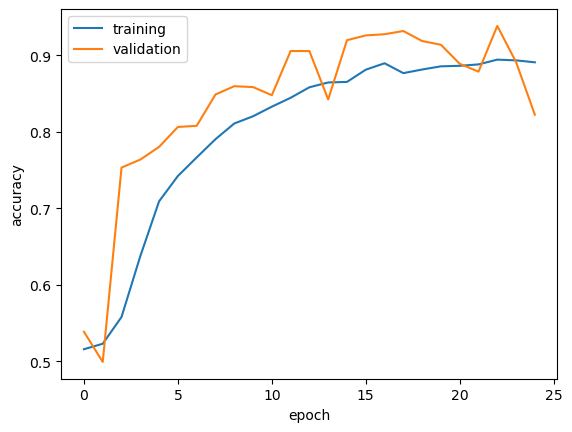

In [6]:
# Apply the vectorization layer to the dataset
title_train_vec = train.map(lambda x, y: (title_vectorize_layer(x["title"]), y))
title_test_vec = test.map(lambda x, y: (title_vectorize_layer(x["title"]), y))

#construct sequential model
title_model = tf.keras.Sequential([
  layers.Embedding(input_dim=2000, output_dim=5),
  layers.Dropout(0.4), #avoid overfitting
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(32, activation = "relu"), #improve accuracy
  layers.Dense(2)
])

#compile model
title_model.compile(loss=losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer='adam', 
              metrics=['accuracy'])

#fit model
history = title_model.fit(title_train_vec, epochs = 25, validation_data = title_test_vec,  verbose = 0)

#evaluate accuracy on our 20% testing data (will perform on new testing data for the "best" model later)
title_model.evaluate(title_test_vec)

#plot results using info stored in history variable
plt.plot(history.history["accuracy"], label = "training")
plt.plot(history.history["val_accuracy"], label = "validation")
plt.gca().set(xlabel = "epoch", ylabel = "accuracy")
plt.legend()


Commentary:
- I needed 25 epochs to obtain a relatively flattened out ("fully trained") model. I started with closer to 10 but that did not prove to be enough to obtain highest possible accuracy.
- Some modifications I played around with while makind the model was adding dropout layers, which proved to lower my overfitting. Additionally, I added another dense layer before the output layer which increased my accuracy significantly. Lastly, I found that changing the embedding layer output dimension to 5 yielded best results

### Text model

90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9738 - loss: 0.1543


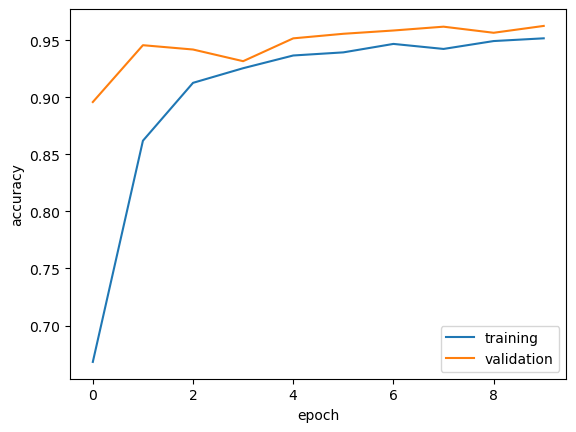

In [7]:
# Apply the vectorization layer to the dataset
text_train_vec = train.map(lambda x, y: (text_vectorize_layer(x["text"]), y))
text_test_vec = test.map(lambda x, y: (text_vectorize_layer(x["text"]), y))

#create model
title_model = tf.keras.Sequential([
  layers.Embedding(input_dim=2000, output_dim=3),
  layers.Dropout(0.2), #avoid overfitting
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(2)
])

#compile model
title_model.compile(loss=losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer='adam', 
              metrics=['accuracy'])

#fit model
history = title_model.fit(text_train_vec, epochs = 10, validation_data = text_test_vec, verbose = 0)

#evaluate accuracy on our 20% testing data (will perform on new testing data for the "best" model later)
title_model.evaluate(text_test_vec)

#plot results using info stored in history variable
plt.plot(history.history["accuracy"], label = "training")
plt.plot(history.history["val_accuracy"], label = "validation")
plt.gca().set(xlabel = "epoch", ylabel = "accuracy")
plt.legend()

Commentary:
- This time I only needed 10 epochs to obtain a well trained model, because the line flattened out in accuracy much quicker
- This model appears to be much more consistent in it's ability to predict fake news correctly based on the validation data
- I created a much simpler model this time because adding layers was not necessary to increase accuracy. However like last time, I did include dropout layers to limit overfitting. I found that this time an embedding layer dimension of 3 yielded the best results 

### Text and Title model

2024-06-02 17:20:06.479336: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ title (InputLayer)  │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ text (InputLayer)   │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ text_vectorization… │ (None, 500)       │          0 │ title[0][0],      │
│ (TextVectorization) │                   │            │ text[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_2         │ (None, 500, 3)    │      6,000 │ text_vectorizati… │
│ (Embedding)         │                   │            │ text_vectorizati… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 500, 3)    │          0 │ embedding_2[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 500, 3)    │          0 │ embedding_2[1][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 3)         │          0 │ dropout_4[0][0]   │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 3)         │          0 │ dropout_5[0][0]   │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 6)         │          0 │ global_average_p… │
│ (Concatenate)       │                   │            │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 32)        │        224 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 32)        │          0 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 32)        │      1,056 │ dropout_6[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fake (Dense)        │ (None, 2)         │         66 │ dense_4[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 7,346 (28.70 KB)

 Trainable params: 7,346 (28.70 KB)

 Non-trainable params: 0 (0.00 B)

90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9848 - loss: 0.0361


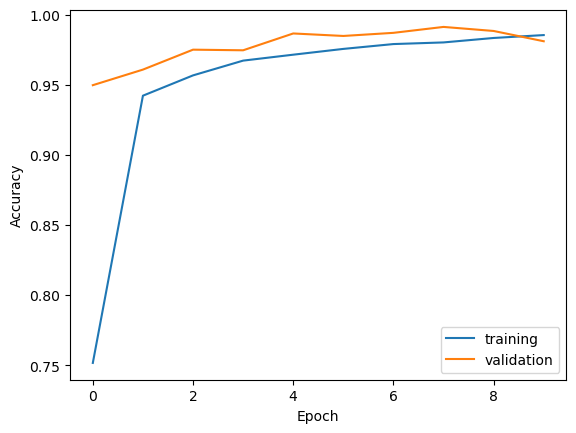

In [8]:

# Establish shared text vectorization layer
# Necessary to use shared embedding layer later
vectorize_layer = tf.keras.layers.TextVectorization(
    standardize=standardization,
    max_tokens=size_vocabulary,
    output_mode='int',
    output_sequence_length=500
)

# Adapt the vectorization layer to the dataset
all_titles_texts = train.map(lambda x, y: tf.concat([x["title"], x["text"]], axis=0))
vectorize_layer.adapt(all_titles_texts)

# Shared Embedding layer
embedding_layer = tf.keras.layers.Embedding(input_dim=size_vocabulary, output_dim=3)

# Define input layers
title_input = tf.keras.Input(shape=(1,), name="title", dtype=tf.string)
text_input = tf.keras.Input(shape=(1,), name="text", dtype=tf.string)

# Apply shared TextVectorization and Embedding layers to input layers
def vectorize_and_embed(input_text):
    '''
    Function to streamline the vectorization and embedding
    Take in an input data layer and perform both operations, return the embedded and vectorized layer
    '''
    vectorized_text = vectorize_layer(input_text)
    embedded_text = embedding_layer(vectorized_text)
    return embedded_text

title_features = vectorize_and_embed(title_input)
text_features = vectorize_and_embed(text_input)

# Dropout and pooling layers
title_features = tf.keras.layers.Dropout(0.2)(title_features)
text_features = tf.keras.layers.Dropout(0.2)(text_features)
title_features = tf.keras.layers.GlobalAveragePooling1D()(title_features)
text_features = tf.keras.layers.GlobalAveragePooling1D()(text_features)

# Concatenate features
concatenated_features = tf.keras.layers.concatenate([title_features, text_features], axis=1)

# Dense layers
dense1 = tf.keras.layers.Dense(32, activation='relu')(concatenated_features)
dropout = tf.keras.layers.Dropout(0.2)(dense1)
dense2 = tf.keras.layers.Dense(32, activation='relu')(dropout)

# Output layer
output = tf.keras.layers.Dense(2, name="fake")(dense2)

# Define model
model = tf.keras.Model(inputs=[title_input, text_input], outputs=output)

# Compile model
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=['accuracy'])

# Model summary
model.summary()

#Save a copy of the model for later to use in next step!! then we will retrain and test on new data
model_copy = model

# Train the model
history = model.fit(train, epochs=10, validation_data=test, verbose = 0)

#evaluate accuracy on our 20% testing data (will perform on new testing data for the "best" model later)
model.evaluate(test)

#plot results
plt.plot(history.history["accuracy"], label="training")
plt.plot(history.history["val_accuracy"], label="validation")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


Commentary:
- This time I used the functional API rather than sequential in order to incorporate both title and text data into the model training
- Because I used a shared embedding layer, I also did a combined text vectorization instead of vectorizing each seperately as before
- I played around with adding two dense layers, as well as dropout layers with the pooling layers and found the combination I used to have the best results. We can see from the graph that the model is trained extremely quickly (after just a few epochs) and reaches the highest accuracy we have seen thus far.

## Three Model Comparison

Algorithms should use both title and text when seeking to detect fake news. I am able to clearly come to this conclusion after seeing that my combined model of both title and text achieved the highest accuracy score when compared with my models that just use title or text individually.

Furthermore, this combined model preforms extremely well, consistently scoring at around a ***98%*** accuracy thus far. We will see below if this high accuracy extends to unseen testing data.

## Model Evaluation

Now we’ll test model performance on unseen test data. For this part, I will only focus on the best model (combined title and text).

The test data is provided here:

    test_url = "https://github.com/PhilChodrow/PIC16b/blob/master/datasets/fake_news_test.csv?raw=true"

In [9]:
#download data
test_data = pd.read_csv(f'https://github.com/PhilChodrow/PIC16b/blob/master/datasets/fake_news_test.csv?raw=true')

#make dataset using function defined earlier
test_dataset = make_dataset(test_data)

for epoch in range(10):
    
    # Train for one epoch (use the untrained model found in previous step)
    model_copy.fit(train, epochs=1, validation_data=test_dataset, verbose=0)
    
    # Evaluate accuracy on the test dataset
    loss, accuracy = model_copy.evaluate(test_dataset, verbose=0)
    
    #print accuracy on validation data
    print(f'Test Accuracy after epoch {epoch+1}: {accuracy:.4f}')
    

Test Accuracy after epoch 1: 0.9805
Test Accuracy after epoch 2: 0.9807
Test Accuracy after epoch 3: 0.9801
Test Accuracy after epoch 4: 0.9775
Test Accuracy after epoch 5: 0.9807
Test Accuracy after epoch 6: 0.9785
Test Accuracy after epoch 7: 0.9771
Test Accuracy after epoch 8: 0.9808
Test Accuracy after epoch 9: 0.9813
Test Accuracy after epoch 10: 0.9800


Our accuracy remains very high around 98%, which indicates that our model can be used in the real-world at very high reliability.